# **1. Data Handling**

# 1.1 Load dataset from Kaggle API

In [28]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

os.chdir("..")

dataset_name = 'vishnu0399/emergency-vehicle-siren-sounds'
data_path = './data'

project_path = os.getcwd()
os.environ['KAGGLE_CONFIG_DIR'] = project_path

kaggle_json_path = os.path.join(project_path, 'kaggle.json')
if not os.path.exists(kaggle_json_path):
    print(f"Warning: kaggle.json not found at {kaggle_json_path}")
    print("Please place your kaggle.json file in the project directory")
    exit(1)
else:
    print(f"Found kaggle.json at {kaggle_json_path}")

api = KaggleApi()

try:
    api.authenticate()
    print("Kaggle API authenticated successfully.")

    print(f"Downloading dataset: {dataset_name} to {data_path}")
    api.dataset_download_files(dataset_name, path=data_path, unzip=True)
except Exception as e:
    print(f"An error occurred: {e}")
    print("Kaggle API authentication failed. Please check your credentials.")


Please place your kaggle.json file in the project directory
Kaggle API authenticated successfully.
Dataset URL: https://www.kaggle.com/datasets/vishnu0399/emergency-vehicle-siren-sounds


# 1.2 Dataset file loader and preprocessing functions

In [29]:
import wave
import numpy as np
import struct

# === WAV Loader ===
def read_wav(filename):
    with wave.open(filename, 'rb') as wav_file:
        n_channels, sampwidth, framerate, n_frames, _, _ = wav_file.getparams()
        raw_data = wav_file.readframes(n_frames)
        fmt = "<" + "h" * (n_frames * n_channels)
        data = struct.unpack(fmt, raw_data)
        print(f"📂 Membaca file: {filename} (sample rate: {framerate} Hz, total frames: {n_frames})")
        return np.array(data), framerate
    
# Set random seed for reproducibility
np.random.seed(42)

In [30]:
# === Time Domain ===
def zero_crossing_rate(samples):
    # Vectorized zero crossing rate calculation
    signs = np.sign(samples)
    sign_changes = np.diff(signs)
    zcr = np.count_nonzero(sign_changes) / len(samples)
    print(f"🔹 Zero Crossing Rate: {zcr:.5f}")
    return zcr

def energy(samples):
    # Vectorized energy calculation
    en = np.mean(samples**2)
    print(f"🔹 Signal Energy: {en:.2f}")
    return en

In [31]:
from scipy.fft import fft

# === Frequency Domain (FFT + Dominant Frequency) ===
def fft(samples):
    print(f"🔸 Applying FTT to {len(samples)} samples...")
    # Use NumPy's FFT implementation
    fft_result = np.fft.fft(samples)
    magnitudes = np.abs(fft_result)
    return magnitudes

def dominant_freq(magnitudes, sample_rate):
    # Find dominant frequency using NumPy
    max_index = np.argmax(magnitudes)
    freq = max_index * sample_rate / len(magnitudes)
    print(f"🔹 Dominant Frequency: {freq:.2f} Hz")
    return freq

In [32]:
# === MFCC ===
def pre_emphasis(signal, coeff=0.97):
    # Vectorized pre-emphasis filter
    emphasized = np.zeros_like(signal)
    emphasized[0] = signal[0]
    emphasized[1:] = signal[1:] - coeff * signal[:-1]
    return emphasized

def hamming_window(N):
    # Use NumPy's hamming window
    return np.hamming(N)

def hz_to_mel(hz):
    return 2595 * np.log10(1 + hz / 700)

def mel_to_hz(mel):
    return 700 * (10**(mel / 2595) - 1)

def mel_filterbank(n_filters, N_fft, sample_rate):
    # Vectorized mel filterbank creation
    low_mel = hz_to_mel(0)
    high_mel = hz_to_mel(sample_rate / 2)
    
    # Create mel points
    mel_points = np.linspace(low_mel, high_mel, n_filters + 2)
    hz_points = mel_to_hz(mel_points)
    bin_points = np.floor(hz_points * N_fft / sample_rate).astype(int)
    
    # Create filter bank matrix
    filters = np.zeros((n_filters, N_fft // 2))
    
    for i in range(1, n_filters + 1):
        left = bin_points[i - 1]
        center = bin_points[i]
        right = bin_points[i + 1]
        
        # Left slope
        for j in range(left, center):
            if j < filters.shape[1]:
                filters[i - 1, j] = (j - left) / (center - left)
        
        # Right slope
        for j in range(center, right):
            if j < filters.shape[1]:
                filters[i - 1, j] = (right - j) / (right - center)
    
    return filters

def apply_filterbanks(magnitudes, filters):
    # Vectorized filterbank application
    # Ensure magnitudes length matches filter bank width
    mag_len = min(len(magnitudes), filters.shape[1])
    magnitudes_truncated = magnitudes[:mag_len]
    filters_truncated = filters[:, :mag_len]
    
    # Apply filters using matrix multiplication
    energies = np.dot(filters_truncated, magnitudes_truncated)
    # Add small epsilon to avoid log(0)
    energies = np.log(energies + 1e-10)
    return energies

def dct(signal):
    # Vectorized DCT implementation
    N = len(signal)
    n = np.arange(N)
    k = np.arange(N).reshape(-1, 1)
    
    # DCT matrix
    dct_matrix = np.cos(np.pi * k * (2 * n + 1) / (2 * N))
    result = np.dot(dct_matrix, signal)
    return result

def mfcc(samples, sample_rate, num_filters=26, num_coeffs=13):
    print("🔸 Calculating MFCC...")
    
    # Pre-emphasis
    emphasized = pre_emphasis(samples)
    
    # Windowing
    frame_size = int(0.025 * sample_rate)
    frame = emphasized[:frame_size]
    hamming = hamming_window(len(frame))
    windowed = frame * hamming
    
    # FFT
    spectrum = fft(windowed)
    
    # Mel filterbank
    filters = mel_filterbank(num_filters, len(spectrum) * 2, sample_rate)
    
    # Apply filterbanks
    energies = apply_filterbanks(spectrum, filters)
    
    # DCT
    cepstrals = dct(energies)
    mfccs = cepstrals[:num_coeffs]
    
    print(f"🔹 MFCC (13 coeff): {np.round(mfccs, 2).tolist()}")
    return mfccs.tolist()

In [33]:
# === Feature Extraction ===
def extract_features(file_path):
    print(f"\n📥 Feature extraction from: {file_path}")
    samples, sample_rate = read_wav(file_path)
    
    zcr = zero_crossing_rate(samples)
    en = energy(samples)
    
    # Use first 512 samples for FFT
    fft_samples = samples[:512] if len(samples) >= 512 else samples
    fft_mags = fft(fft_samples)
    dom_freq = dominant_freq(fft_mags, sample_rate)
    
    mfcc_feats = mfcc(samples, sample_rate)
    
    return [zcr, en, dom_freq] + mfcc_feats

# 1.3 Load, encode label, and split dataset for use

In [34]:
# === Load Dataset ===
def load_dataset(folder_path):
    data = []
    labels = []
    print(f"📁 Loading dataset from: {folder_path}")
    
    for label in os.listdir(folder_path):
        label_folder = os.path.join(folder_path, label)
        if not os.path.isdir(label_folder):
            continue
            
        print(f"\n🗂️ Label: {label}")
        for filename in os.listdir(label_folder):
            if not filename.lower().endswith('.wav'):
                continue  # Lewati .png dan .py
                
            path = os.path.join(label_folder, filename)
            try:
                features = extract_features(path)
                data.append(features)
                labels.append(label)
            except Exception as e:
                print(f"⚠️ Failed to process {path}: {e}")
    
    return np.array(data), labels

def encode_labels(labels):
    unique_labels = list(set(labels))
    label_to_int = {label: i for i, label in enumerate(unique_labels)}
    print(f"\n🔢 Label encoding: {label_to_int}")
    encoded_labels = np.array([label_to_int[label] for label in labels])
    return encoded_labels, label_to_int

def train_test_split(data, labels, ratio=0.8, shuffle=False):
    n_train = int(len(data) * ratio)
    
    if shuffle:
        # Shuffle data before splitting
        indices = np.random.permutation(len(data))
        train_indices = indices[:n_train]
        test_indices = indices[n_train:]
        print(f"🔄 Split data (shuffled): {n_train} train, {len(data) - n_train} test")
        return (data[train_indices], labels[train_indices],
                data[test_indices], labels[test_indices])
    else:
        # Sequential split (like original)
        print(f"🔄 Split data (sequential): {n_train} train, {len(data) - n_train} test")
        return (data[:n_train], labels[:n_train],
                data[n_train:], labels[n_train:])

In [35]:
dataset_path = "./data/sounds"

data, labels = load_dataset(dataset_path)
labels_encoded, label_map = encode_labels(labels)

📁 Loading dataset from: ./data/sounds

🗂️ Label: ambulance

📥 Feature extraction from: ./data/sounds\ambulance\sound_1.wav
📂 Membaca file: ./data/sounds\ambulance\sound_1.wav (sample rate: 44100 Hz, total frames: 132300)
🔹 Zero Crossing Rate: 0.34868
🔹 Signal Energy: 537020.02
🔸 Applying FTT to 512 samples...
🔹 Dominant Frequency: 0.00 Hz
🔸 Calculating MFCC...
🔸 Applying FTT to 1102 samples...
🔹 MFCC (13 coeff): [-598.67, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0]

📥 Feature extraction from: ./data/sounds\ambulance\sound_10.wav
📂 Membaca file: ./data/sounds\ambulance\sound_10.wav (sample rate: 44100 Hz, total frames: 132300)
🔹 Zero Crossing Rate: 0.35828
🔹 Signal Energy: 524630.68
🔸 Applying FTT to 512 samples...
🔹 Dominant Frequency: 0.00 Hz
🔸 Calculating MFCC...
🔸 Applying FTT to 1102 samples...
🔹 MFCC (13 coeff): [144.18, -19.75, 3.29, -0.23, -2.02, 3.63, -3.64, 0.64, 1.13, 0.17, 1.84, -0.34, 1.69]

📥 Feature extraction from: ./data/sounds\ambulance\sound_100

# **2. KNN Model**

# 2.1 Define KNN model and evaluations

In [36]:
# === K-NN ===
def euclidean_distance(a, b):
    # Vectorized Euclidean distance
    return np.sqrt(np.sum((a - b)**2))

def predict_knn(train_data, train_labels, test_point, k=3):
    # Vectorized distance calculation for all training points
    distances = np.array([euclidean_distance(test_point, td) for td in train_data])
    
    # Get k nearest neighbors
    k_indices = np.argsort(distances)[:k]
    k_labels = train_labels[k_indices]
    
    # Return most common label
    unique_labels, counts = np.unique(k_labels, return_counts=True)
    return unique_labels[np.argmax(counts)]



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns

def plot_knn_analysis(X_train, X_test, y_train, y_test):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Validation Curve (Performance vs K values)
    k_range = np.arange(1, 31)
    train_scores, val_scores = validation_curve(
        KNeighborsClassifier(), X_train, y_train,
        param_name='n_neighbors', param_range=k_range,
        cv=5, scoring='accuracy'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    ax1.plot(k_range, train_mean, 'o-', color='blue', label='Training Score')
    ax1.fill_between(k_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    ax1.plot(k_range, val_mean, 'o-', color='red', label='Validation Score')
    ax1.fill_between(k_range, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
    ax1.set_xlabel('Number of Neighbors (K)')
    ax1.set_ylabel('Accuracy Score')
    ax1.set_title('KNN Validation Curve')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Learning Curve (Performance vs Training Size)
    train_sizes, train_scores_lc, val_scores_lc = learning_curve(
        KNeighborsClassifier(n_neighbors=5), X_train, y_train,
        cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
    )
    
    train_mean_lc = np.mean(train_scores_lc, axis=1)
    train_std_lc = np.std(train_scores_lc, axis=1)
    val_mean_lc = np.mean(val_scores_lc, axis=1)
    val_std_lc = np.std(val_scores_lc, axis=1)
    
    ax2.plot(train_sizes, train_mean_lc, 'o-', color='blue', label='Training Score')
    ax2.fill_between(train_sizes, train_mean_lc - train_std_lc, train_mean_lc + train_std_lc, alpha=0.1, color='blue')
    ax2.plot(train_sizes, val_mean_lc, 'o-', color='red', label='Validation Score')
    ax2.fill_between(train_sizes, val_mean_lc - val_std_lc, val_mean_lc + val_std_lc, alpha=0.1, color='red')
    ax2.set_xlabel('Training Set Size')
    ax2.set_ylabel('Accuracy Score')
    ax2.set_title('KNN Learning Curve')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Distance Metrics Comparison
    distance_metrics = ['euclidean', 'manhattan', 'minkowski']
    metric_scores = []
    
    for metric in distance_metrics:
        knn = KNeighborsClassifier(n_neighbors=5, metric=metric)
        knn.fit(X_train, y_train)
        score = knn.score(X_test, y_test)
        metric_scores.append(score)
    
    bars = ax3.bar(distance_metrics, metric_scores, color=['blue', 'green', 'orange'], alpha=0.7)
    ax3.set_ylabel('Test Accuracy')
    ax3.set_title('Distance Metrics Comparison')
    ax3.set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, score in zip(bars, metric_scores):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Cross-validation scores for different K values
    k_range_cv = range(1, 21)
    cv_scores = []
    cv_stds = []
    
    for k in k_range_cv:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = validation_curve(knn, X_train, y_train, 
                                param_name='n_neighbors', param_range=[k],
                                cv=5, scoring='accuracy')[1]
        cv_scores.append(np.mean(scores))
        cv_stds.append(np.std(scores))
    
    ax4.errorbar(k_range_cv, cv_scores, yerr=cv_stds, fmt='o-', capsize=5)
    ax4.set_xlabel('Number of Neighbors (K)')
    ax4.set_ylabel('Cross-Validation Accuracy')
    ax4.set_title('Cross-Validation Scores with Error Bars')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print optimal K
    optimal_k = k_range[np.argmax(val_mean)]
    print(f"\nOptimal K value: {optimal_k}")
    print(f"Best validation accuracy: {max(val_mean):.4f} ± {val_std[np.argmax(val_mean)]:.4f}")

In [45]:
def evaluate(train_data, train_labels, test_data, test_labels):
    print("\n🧪 Evaluate model (k-NN)...")
    
    predictions = []
    for i, test_point in enumerate(test_data):
        pred = predict_knn(train_data, train_labels, test_point)
        predictions.append(pred)
        actual = test_labels[i]
        print(f"   ▸ Test {i+1}: Pred = {pred}, Label = {actual} --> {'✅' if pred == actual else '❌'}")
    
    predictions = np.array(predictions)
    accuracy = float(np.mean(predictions == test_labels))
    print(f"\n🎯 Accuracy: {accuracy*100:.2f}%")

    # Create visualizations
    plot_knn_analysis(train_data, test_data, train_labels, test_labels)

# 2.2 Train and evaluate k-NN

🔄 Split data (sequential): 480 train, 120 test

🧪 Evaluate model (k-NN)...
   ▸ Test 1: Pred = 2, Label = 2 --> ✅
   ▸ Test 2: Pred = 0, Label = 2 --> ❌
   ▸ Test 3: Pred = 2, Label = 2 --> ✅
   ▸ Test 4: Pred = 2, Label = 2 --> ✅
   ▸ Test 5: Pred = 2, Label = 2 --> ✅
   ▸ Test 6: Pred = 0, Label = 2 --> ❌
   ▸ Test 7: Pred = 2, Label = 2 --> ✅
   ▸ Test 8: Pred = 2, Label = 2 --> ✅
   ▸ Test 9: Pred = 2, Label = 2 --> ✅
   ▸ Test 10: Pred = 2, Label = 2 --> ✅
   ▸ Test 11: Pred = 2, Label = 2 --> ✅
   ▸ Test 12: Pred = 2, Label = 2 --> ✅
   ▸ Test 13: Pred = 2, Label = 2 --> ✅
   ▸ Test 14: Pred = 2, Label = 2 --> ✅
   ▸ Test 15: Pred = 2, Label = 2 --> ✅
   ▸ Test 16: Pred = 0, Label = 2 --> ❌
   ▸ Test 17: Pred = 1, Label = 2 --> ❌
   ▸ Test 18: Pred = 1, Label = 2 --> ❌
   ▸ Test 19: Pred = 1, Label = 2 --> ❌
   ▸ Test 20: Pred = 2, Label = 2 --> ✅
   ▸ Test 21: Pred = 2, Label = 2 --> ✅
   ▸ Test 22: Pred = 2, Label = 2 --> ✅
   ▸ Test 23: Pred = 2, Label = 2 --> ✅
   ▸ Test 24: 

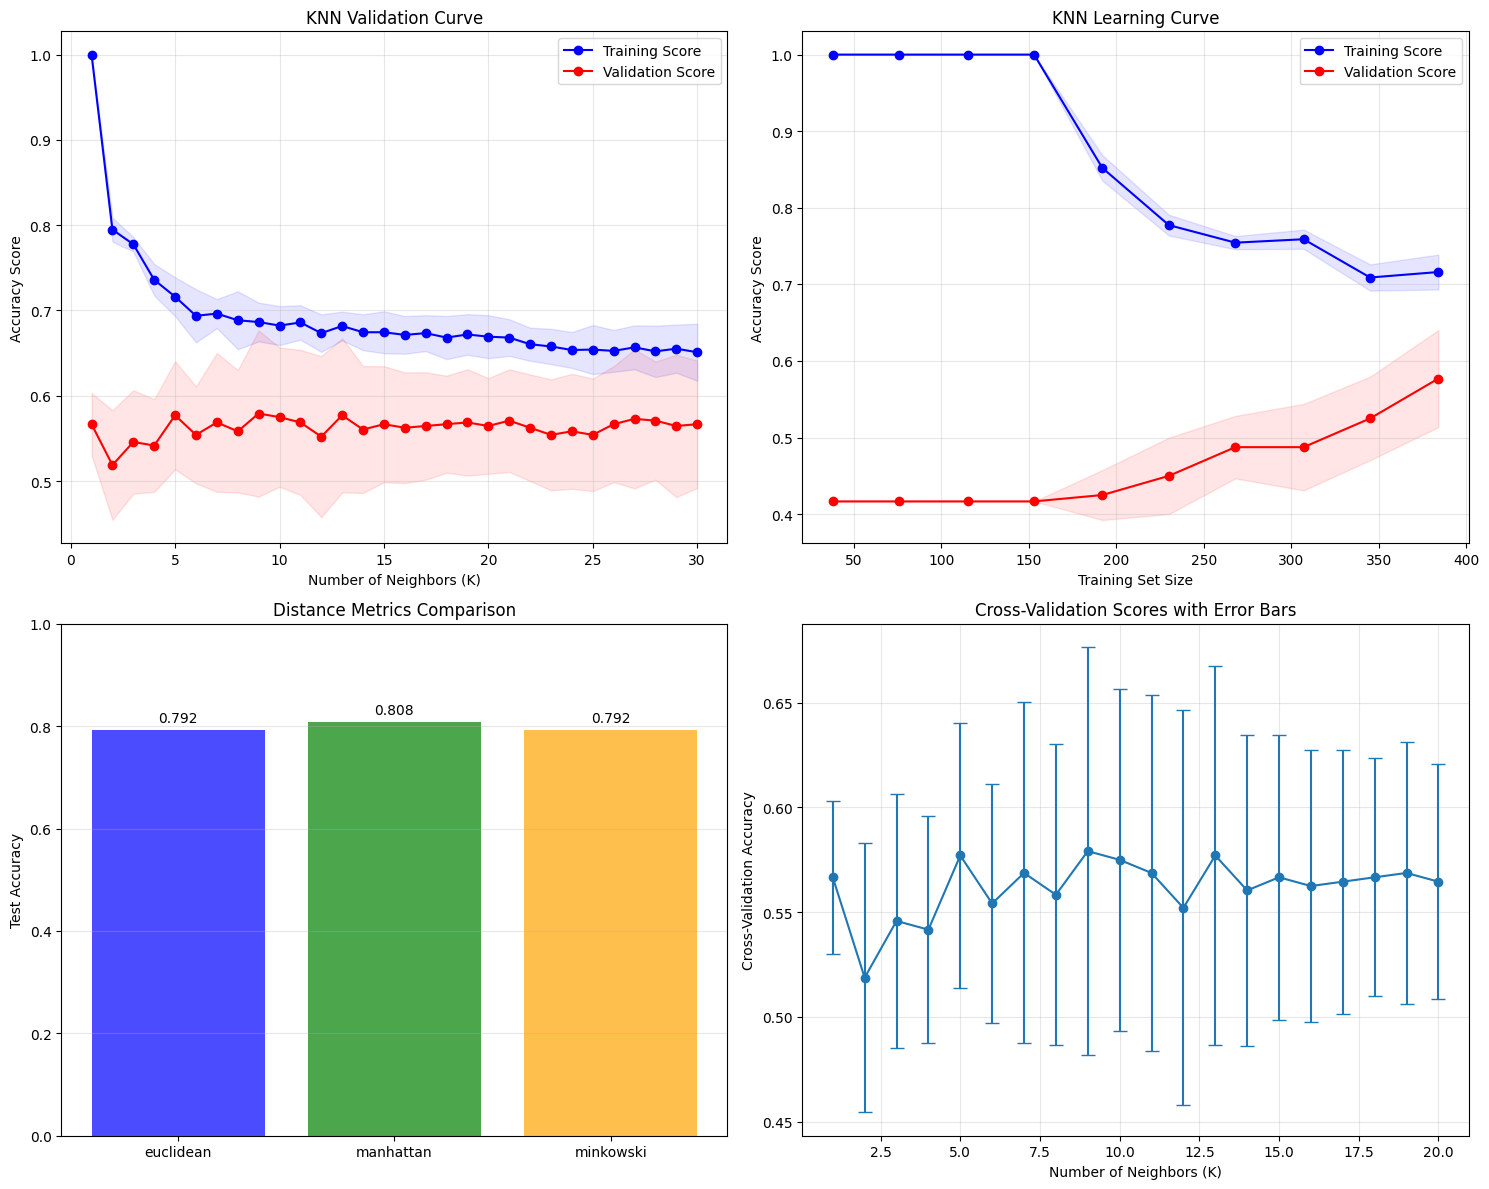


Optimal K value: 9
Best validation accuracy: 0.5792 ± 0.0974


In [46]:
train_data, train_labels, test_data, test_labels = train_test_split(data, labels_encoded, shuffle=False)

evaluate(train_data, train_labels, test_data, test_labels)

# 2.3 Save model as json for streamlit use

In [ ]:
import json

# === Save Model ===
def save_model(train_data, train_labels, label_map, k, filename='siren_knn_model.json'):
    model = {
        'data': train_data.tolist(),
        'labels': train_labels.tolist(),
        'label_map': label_map,
        'k': k, 
    }
    
    with open(filename, 'w') as f:
        json.dump(model, f)
    print(f"\n✅ Model saved as: {filename}")

save_model(train_data, train_labels, label_map, k=9)


✅ Model saved as: siren_knn_model.json
